# Analysis of Abundance Data (aka Fitting Models to Abundance Data) <a class="tocSkip">

<!--NAVIGATION-->

<[Back to Workshop Contents](Index.ipynb)>

<div id="toc"> </div>

## Introduction

### Why Abundances?

Fluctuations in the abundance (density) of a disease's vector play a crucial role in its transmission dynamics. THis sespecially true if vector population densities or their [traits](Traits.ipynb) change at the same or shorter timescales than the rate of disease transmission. Indeed, most vectors are small ectotherms with short generation times and greater sensitivity to environmental conditions than their (invariably larger, longer-lived, and often, endothermic) hosts. So understanding how vector populations vary over time and space is key. This section of the training workshop is focused on teaching some techniques for analysis of abundance data. These techniques can also be applies to the analysis of variation in disease incidence, and some examples of such applicationsare also covered.

As we did in the [Traits](Traits.ipynb) workshop, we will first do NLLS fitting before moving on tho Maximum likelihood and Bayesian fitting.  

## Population growth rate

In general, a population grows exponentially while its abundance is low and resources are not limiting. This growth then slows and eventually stops as resources become limiting. There may also be a time lag before the population growth really takes off at the start. We will focus on microbial (specifically, bacterial) growth rates. Bacterial growth in batch culture follows a distinct set of phases; lag phase, exponential phase and stationary phase. During the lag phase a suite of transcriptional machinery is activated, including genes involved in nutrient uptake and metabolic changes, as bacteria prepare for growth. During the exponential growth phase, bacteria divide at a constant rate, the population doubling with each generation. When the carrying capacity of the media is reached, growth slows and the number of cells in the culture stabilises, beginning the stationary phase.

Traditionally, growth rate can be measured by plotting out cell numbers or culture density against time on a semi-log graph and fitting a straight line through the exponential growth phase - the slope of the line gives the maximum growth rate ($r_{max}$). Models have since been devised which we can use to describe the whole sigmoidal bacterial growth curve. 

Let's first generate some "data" on the number of bacterial cells as a function of time that we can play with:

In [1]:
time <- c(0, 2, 4, 6, 8, 10, 12, 16, 20, 24) # timepoints, in hours
log_cells <- c(3.62, 3.62, 3.63, 4.14, 5.23, 6.27, 7.57, 8.38, 8.70, 8.69) # logged cell counts - more on this below

data <- data.frame(time, log_cells) + rnorm(length(time),sd=.1) # add some random error

names(data) <- c("t", "LogN")

We have added a vector of normally distributed errors to emulate random "sampling errors". Note also that the the assumption of normality of these errors underlies the statistical analyses of Ordinary NLLS fits just as it underies Ordinary Least Squares (your standard linear modelling).

Plot the data:

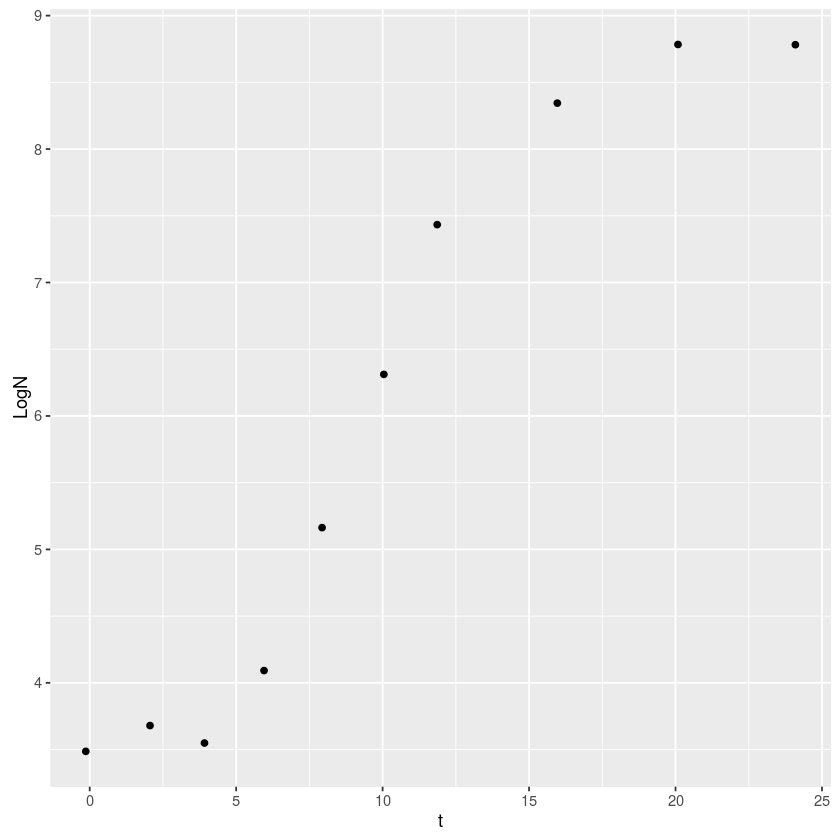

In [22]:
ggplot(data, aes(x = t, y = LogN)) + geom_point()

We will fit three growth models, all of which are known to fit such population growth data, especially in microbes. These are a modified Gompertz model (Zwietering et. al., 1990), the Baranyi model (Baranyi, 1993) and the Buchanan model (or three-phase logistic model; Buchanan, 1997). Given a set of cell numbers (N) and times (t), each growth model can be described in terms of:

$N_0$:  Initial cell culture (Population) density (number of cells per unit volume)  

$N_{max}$: Maximum culture density (aka "carrying capacity") 

$r_{max}$: Maximum growth rate 

$t_{lag}$: Duration of the lag phase before the population starts growing exponentially
   
First let's specify the model functions:

In [23]:
baranyi_model <- function(t, r_max, N_max, N_0, t_lag){  # Baranyi model (Baranyi 1993)
return(N_max + log10((-1+exp(r_max*t_lag) + exp(r_max*t))/(exp(r_max*t) - 1 + exp(r_max*t_lag) * 10^(N_max-N_0))))
}


buchanan_model <- function(t, r_max, N_max, N_0, t_lag){ # Buchanan model - three phase logistic (buchanan 1997)
  return(N_0 + (t >= t_lag) * (t <= (t_lag + (N_max - N_0) * log(10)/r_max)) * r_max * (t - t_lag)/log(10) +
           (t >= t_lag) * (t > (t_lag + (N_max - N_0) * log(10)/r_max)) * (N_max - N_0))
}


gompertz_model <- function(t, r_max, N_max, N_0, t_lag){  # Modified gompertz growth model (Zwietering 1990)
  return(N_0 + (N_max - N_0) * exp(-exp(r_max * exp(1) * (t_lag - t)/((N_max - N_0) * log(10)) + 1)))
}


It is important to note that we have written the funcions in log (to the base 10 - can also be base 2 or natural log) scale. This is because NLLS fitting often converges better in log scale. The interpretation of each of the the estimated/fitted paramters does not change if we take a log of the model's equation.    

Now let's generate some starting values for the NLLS fitting. We did not pay much attention to what starting values we used in the above example on fitting an allometric model because the power-law model is easy to fit using NLLS, and starting far from the optimal parameters does not matter too much. Here, we derive the starting values by using the actual data:  

In [24]:
N_0_start <- min(data$LogN)
N_max_start <- max(data$LogN)
t_lag_start <- data$t[which.max(diff(diff(data$LogN)))]
r_max_start <- max(diff(data$LogN))/mean(diff(data$t))

Now fit the models:

In [25]:
fit_baranyi <- nlsLM(LogN ~ baranyi_model(t = t, r_max, N_max, N_0, t_lag), data,
              list(t_lag=t_lag_start, r_max=r_max_start, N_0 = N_0_start, N_max = N_max_start))

fit_buchanan <- nlsLM(LogN ~ buchanan_model(t = t, r_max, N_max, N_0, t_lag), data,
                        list(t_lag=t_lag_start, r_max=r_max_start, N_0 = N_0_start, N_max = N_max_start))

fit_gompertz <- nlsLM(LogN ~ gompertz_model(t = t, r_max, N_max, N_0, t_lag), data,
                      list(t_lag=t_lag_start, r_max=r_max_start, N_0 = N_0_start, N_max = N_max_start))

Warning message in baranyi_model(t = t, r_max, N_max, N_0, t_lag):
“NaNs produced”Warning message in baranyi_model(t = t, r_max, N_max, N_0, t_lag):
“NaNs produced”Warning message in baranyi_model(t = t, r_max, N_max, N_0, t_lag):
“NaNs produced”

You might get a warning message such as:

`Warning message in baranyi_model(t = t, r_max, N_max, N_0, t_lag):
“NaNs produced”`

This just means that the Baranyi model generated some NaNs during the fitting procedure for the given data. You can ignore it in this case (but not always - sometimes these NaNs mean that the equation is wrongly written, or that it generates NaNs across the whole range of the x-values, in which case the model is inappropriate for these data).     

Get the model summaries:

In [26]:
summary(fit_baranyi)
summary(fit_buchanan)
summary(fit_gompertz)


Formula: LogN ~ baranyi_model(t = t, r_max, N_max, N_0, t_lag)

Parameters:
      Estimate Std. Error t value Pr(>|t|)    
t_lag  5.23445    0.39510   13.25 1.14e-05 ***
r_max  1.34149    0.09418   14.24 7.48e-06 ***
N_0    3.54887    0.09488   37.40 2.44e-08 ***
N_max  8.65373    0.09067   95.45 8.91e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.153 on 6 degrees of freedom

Number of iterations to convergence: 17 
Achieved convergence tolerance: 1.49e-08



Formula: LogN ~ buchanan_model(t = t, r_max, N_max, N_0, t_lag)

Parameters:
      Estimate Std. Error t value Pr(>|t|)    
t_lag  4.13715    0.73469   5.631  0.00134 ** 
r_max  0.99942    0.08768  11.398 2.73e-05 ***
N_0    3.57192    0.16900  21.136 7.31e-07 ***
N_max  8.78296    0.20698  42.433 1.15e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2927 on 6 degrees of freedom

Number of iterations to convergence: 6 
Achieved convergence tolerance: 1.49e-08



Formula: LogN ~ gompertz_model(t = t, r_max, N_max, N_0, t_lag)

Parameters:
      Estimate Std. Error t value Pr(>|t|)    
t_lag  5.47660    0.23460   23.34 4.05e-07 ***
r_max  1.46198    0.07087   20.63 8.44e-07 ***
N_0    3.55900    0.05991   59.41 1.53e-09 ***
N_max  8.84733    0.07520  117.64 2.54e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.09735 on 6 degrees of freedom

Number of iterations to convergence: 9 
Achieved convergence tolerance: 1.49e-08


And see how the fits look:

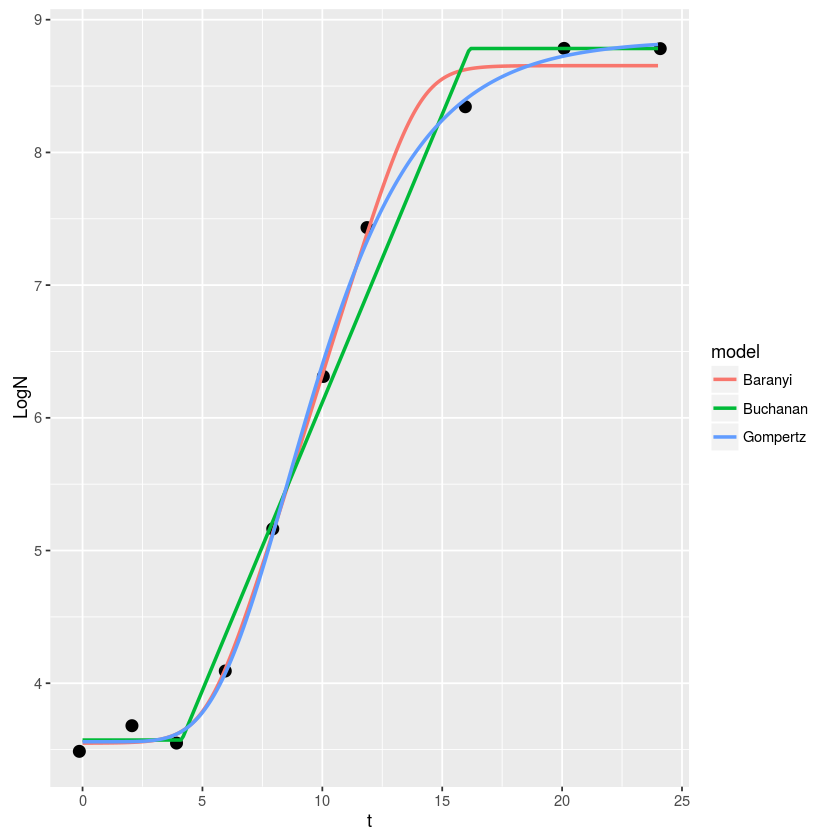

In [27]:
timepoints <- seq(0, 24, 0.1)
baranyi_points <- baranyi_model(t = timepoints, r_max = coef(fit_baranyi)["r_max"], N_max = coef(fit_baranyi)["N_max"],
                                N_0 = coef(fit_baranyi)["N_0"], t_lag = coef(fit_baranyi)["t_lag"])
buchanan_points <- buchanan_model(t = timepoints, r_max = coef(fit_buchanan)["r_max"], N_max = coef(fit_buchanan)["N_max"],
                                N_0 = coef(fit_buchanan)["N_0"], t_lag = coef(fit_buchanan)["t_lag"])
gompertz_points <- gompertz_model(t = timepoints, r_max = coef(fit_gompertz)["r_max"], N_max = coef(fit_gompertz)["N_max"],
                                N_0 = coef(fit_gompertz)["N_0"], t_lag = coef(fit_gompertz)["t_lag"])

df1 <- data.frame(timepoints, baranyi_points)
df1$model <- "Baranyi"
names(df1) <- c("t", "LogN", "model")

df2 <- data.frame(timepoints, buchanan_points)
df2$model <- "Buchanan"
names(df2) <- c("t", "LogN", "model")

df3 <- data.frame(timepoints, gompertz_points)
df3$model <- "Gompertz"
names(df3) <- c("t", "LogN", "model")

model_frame <- rbind(df1, df2, df3)

ggplot(data, aes(x = t, y = LogN)) +
  geom_point(size = 3) +
  geom_line(data = model_frame, aes(x = t, y = LogN, col = model), size = 1)

#### Exercises

(a) Calculate the confidence intervals on the parameters of each of the three fitted models, and use model selection (using AIC and/or BIC) as you did before to find the best-fitting model of the three

(b) Repeat the model comparison exercise 1000 times (You will have to write a loop), and determine whether one model generally wins more often than the others. Note that each run will generate a slightly different dataset, because we are adding a vector of random errors every time the "data" are generated.

(c) Repeat (b), but increase the error by increasing the standard deviation of the normal error distributon, and see if there are differences in the robustness of the models to sampling/experimental errors. You may also want to try changing the distribution of the errors to some non-normal distribution and see what happens.

### Practical

Fit some real data to these models! These data have been generated/collected by [Tom Smith](https://mhasoba.pythonanywhere.com/pawarlab/default/people), a PhD student at Silwood as part of his Dissertation research. Import the [dataset](https://github.com/mhasoba/TheMulQuaBio/blob/master/Data/example_growth_data.csv) into R: 

In [4]:
BacData <- read.csv("../data/example_growth_data.csv")

head(BacData)
tail(BacData)

ID,bacterial_genus,replicate,trait_name,trait_value,hour
Sch_AE103_02,Flavobacterium,1,Log(cells/mL),5.301030,0
Sch_AE103_02,Flavobacterium,1,Log(cells/mL),5.301030,5
Sch_AE103_02,Flavobacterium,1,Log(cells/mL),6.991226,10
Sch_AE103_02,Flavobacterium,1,Log(cells/mL),8.094820,15
Sch_AE103_02,Flavobacterium,1,Log(cells/mL),8.358316,20
Sch_AE103_02,Flavobacterium,1,Log(cells/mL),8.460296,25


,ID,bacterial_genus,replicate,trait_name,trait_value,hour
963,Wil_SP04_02,Bacillus,4,Log(cells/mL),7.086360,25
964,Wil_SP04_02,Bacillus,4,Log(cells/mL),7.322219,30
965,Wil_SP04_02,Bacillus,4,Log(cells/mL),7.361728,35
966,Wil_SP04_02,Bacillus,4,Log(cells/mL),7.322219,40
967,Wil_SP04_02,Bacillus,4,Log(cells/mL),7.260071,45
968,Wil_SP04_02,Bacillus,4,Log(cells/mL),7.292256,50


The column `trait_value` and `hour` are your variables of interest (log cell density and time), respectively. Note that the `ID` column will tell you which rows represent one separate growth experiment.  Make sure you have a good look at the data first by plotting them up (idealy, in a loop).  

1. Fit the above population growth rate models, and perform model selection on them. Which model fits best? 
* Can you think of a difefrent model to fit? If so, implement it, and compare that as well. 
* Write the analysis as a single self-standing R script, which will run and return the results in a `*.csv` file and plot(s) ins pdf.
* Again, consider using ggplot insted of base plotting.

## Time Series

Analyses of time series is an important tool for quantifying and understanding fluctuations in vector abundance and disease incidence over time. 

Here you will perform a simple analysis of the data on airline passenger data using the time series extensions to linear regression that you learned in the [lecture](https://github.com/vectorbite/VBiTraining/tree/master/lectures). 

Also have a look at the [`VB_TS.R`](https://github.com/vectorbite/VBiTraining/tree/master/code) script first, which contains the weather example covered in the lecture.

### The data

The data you will analyze consist of monthly numbers of international airline passengers from 1949 to 1961. These data can be found in the [`airline.csv`](https://github.com/vectorbite/VBiTraining/raw/master/data/airline.csv) file. 

In [2]:
airline <- read.csv("../data/airline.csv")

First plot the data:

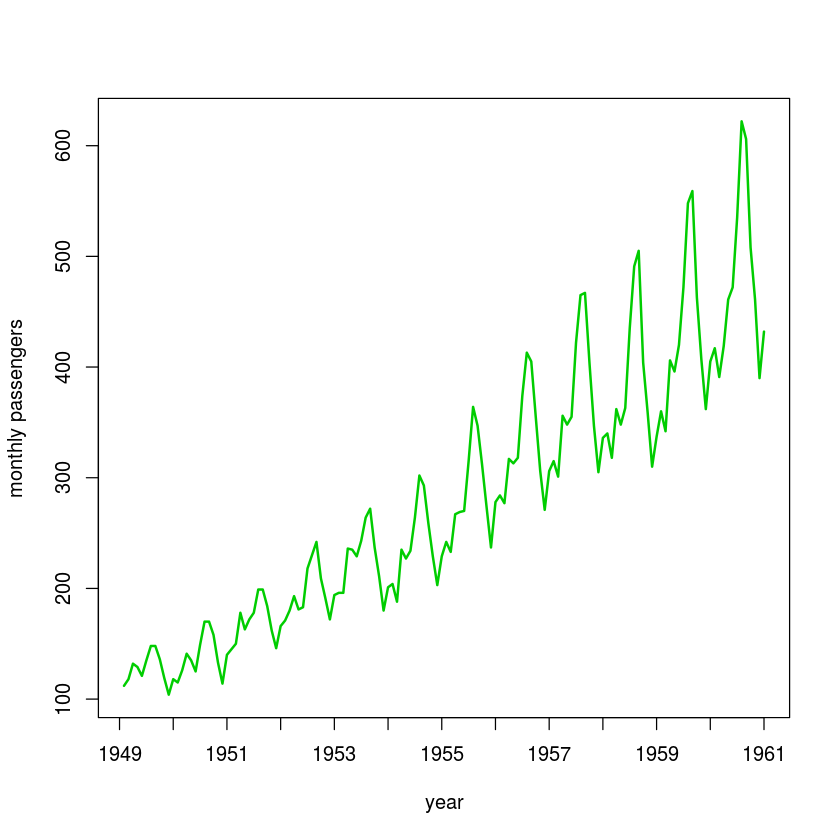

In [3]:
plot(airline$Passengers, xlab="year", ylab="monthly passengers", type="l", col=3, lwd=2, xaxt="n")
axis(1, at=(0:12)*12, labels=1949:1961)

Notice that this involves a somewhat different approach toward adding axis labels than usual. *What does `at="n"` mean? What does the axis function do?* (Check the help doc: `?axis`)

Next, we use the `acf` function to plot the auto-correlation function of the passengers data:

In [ ]:
## put the acf function here


*From the two plots above, what things do you notice about the data? What transforms might you need to take of the data? What kinds of covariates might you need to add in?*

Re-plot the from data above using a log transform of the response (passenger):

In [ ]:
## plot code here

Now it's time to build a data frame to hold the data. This is a good habit to get in to when you are building models for data that include transforms and possibly multiple lags, etc. 

First we make a time covariate:

In [8]:
t <- 2:nrow(airline)

Now, into the data frame, add the following covariates:

1. logY: log of the number of passengers 
2. logYpast: this is your auto-regressive term, the log of the passengers from the previous month
3. t: month number
4. sin12: sine terms with period of 12 months
5. cos12: cosine term with period of 12 months

In [9]:
YX <- data.frame(logY=log(airline$Passengers[2:144]), 
                 logYpast=log(airline$Passengers[1:143]), t=t,
                 sin12=sin(2*pi*t/12), cos12=cos(2*pi*t/12))

In [ ]:
## your fitted model and the summary go here

Fit a linear model with logY as the response and the other 4 components as predictors. Look at the summary of the fit.


*Are all of the predictors significant? What is the $R^2$ of your regression?*

Next, we want to plot the data along with the prediction (aka the fit). I've plotted the data on a log scale (drawn with a dotted line).  Use the "lines" function to overlay the FITTED values from your regression (e.g., if your regression model was called "reg" you want to plot reg$fitted vs t) as a solid line in another color. This solid line is your prediction. Update the legend to reflect your additional line.

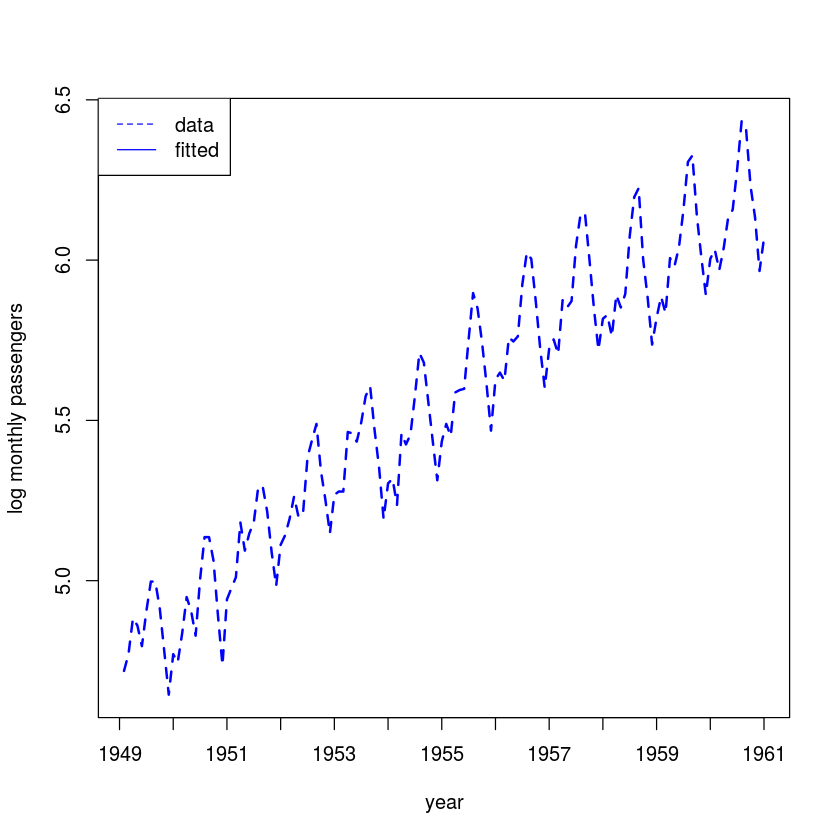

In [11]:
plot(log(airline$Passengers), xlab="year",
     ylab="log monthly passengers", type="l", col=4, lty=2,
     xaxt="n", lwd=2)
axis(1, at=(0:12)*12, labels=1949:1961)

## add in the line here

legend("topleft", legend=c("data", "fitted"), lty=c(2,1), col=c(4,4)) ## update the legend


The difference between the solid and dotted lines at each month are your residuals across time. As always, we want to also look at our residuals explicitly to see if we're doing a good job of explaining things. For TS we primarily look at residuals across time, and the ACF of our residuals. So make those two plots here. 

In [ ]:
par(mfrow=c(1,2))

## residuals plotted across time

## acf plot of the residuals

*How do these look? What do you notice about the residuals, esp the ACF?*

It turns out that there is a month effect that we're missing. Here is one way to look at it (note we have to index by t so that everything lines up properly):

In [ ]:
## this command assumes that your fitted model is called mod1. You'll need to change it to your object

## boxplot(mod1$resid ~ airline$Month[t], xlab="month",
##        ylab="residuals", col=7)

Residuals in months with lots of school holidays (March, summer, December) are consistantly high. Let's create a dummy variable called "holidays" that tells whether a particular passenger record is for a month that has lots of holidays.

In [ ]:
YX$holidays <- airline$Month[t] %in% c(3,6,7,8,12)

Fit a new lm that adds this holiday variable on to what you had before, and then re-examine the residuals, including by month.

In [ ]:
## new fitted model and summary here

## plot of data + model fit here
par(mfrow=c(1,2))
## residuals plotted across time

## acf plot of the residuals

## boxplot of residuals by month


### Model Comparison

Now you have 2 nested models. Because they are nested, we can compare them in two ways. First I do a partial F-test. The idea behind the F-test is that it looks at the difference in the $R^2$ value between the two models and determines whether or not this difference is large enough to warrent the additional covariates. If we use the "anova" function in R and provide both fittend model objects as arguments, it will automatically perform a partial F-test. Note: you will need to replace mod1 and mod2 with the names of your model objects.

In [ ]:
## partial F test: anova(mod1, mod2)

*Based on these what model would you choose and why?*

We can also compare the models via BIC (the Bayesian Information Criterion) and the approximate relative model probabilities based on the BICs. Note that we can use BIC/model probabilities to compare between models even if the models are not nested, as long as the response being modeled is the same in each case. Note: you will need to replace mod1 and mod2 with the names of your model objects.

In [ ]:
n<-length(YX$logY)-1
##bics<-c(mod1=extractAIC(mod1, k=log(n))[2],
##        mod2=extractAIC(mod2, k=log(n))[2])

##ebics<-exp(-0.5*(bics-min(bics)))

##probs<-ebics/sum(ebics)


##rbind(round(bics, 5), round(probs, 5))

*Which model is the best via BIC? Does this jive with what the partial F-test told you? What is the $R^2$ for your best model. Based on this model selection, $R^2$ and what you saw in the residuals for this model, do you feel satisfied that your model is capturing the patterns in the data? Would you want to go back and fit anything else?*

### Practical: A Vector abundance example 

Now how about an anaklysis of some actual vector abundance data. We will use *Aedes aegypti* abundances from light traps from various locations in Manatee County, Florida. This dataset can be downloaded from the [VecDyn database](https://vectorbiteonlineplatform.pythonanywhere.com/VectorBiteDataPlatform/default/). You will need ti register first. The same dataset is also available on the workshop [git repository](https://github.com/vectorbite/VBiTraining) (file called [`vecdyn_manatee_county_a.aegypti.csv`](https://github.com/vectorbite/VBiTraining/raw/master/data/vecdyn_manatee_county_a.aegypti.csv)). 

* Perform a time-series analysis as you did above using these data and write it as an indepndent, self-sufficient R script that produces all the plots in a reproducible workflow when sourced. 

## Readings and Resources <a id='Readings'></a>

* Motulsky, Harvey, and Arthur Christopoulos. Fitting models to biological data using linear and nonlinear regression: a practical guide to curve fitting. OUP USA, 2004.